# 加载模型用于推理或迁移学习

## 概述


在模型训练过程中保存在本地的CheckPoint文件，或从MindSpore Hub下载的CheckPoint文件，都可以帮助用户进行推理或迁移学习使用，提高效率。

以下通过示例来介绍如何通过本地加载加载模型，用于推理验证和迁移学习。

> 本文档适用于GPU、CPU和Ascend环境。

## 整体流程

1. 准备环节。下载数据集，配置运行信息。
2. 数据处理。创建可用于网络训练的数据集，可视化数据集图像。
3. 预训练模型。生成CheckPoint文件。
4. 本地加载模型用于推理验证。
5. 本地加载模型用于迁移学习。

> 本次流程中将网络定义文件（`lenet.py`）、定义数据集预处理函数的文件（`dataset.py`）放在当前工作目录下`./src`目录中，该目录结构为：
> ```bash
> $ tree src
> src
> ├── dataset.py
> ├── __init__.py
> └── lenet.py
> ```

##  准备环节

### 下载数据集

运行以下一段代码,将数据集下载至当前工作目录中`./datasets/MNIST_Data`目录下。

In [1]:
from src.dataset import download_dataset

download_dataset()

******Downloading the MNIST dataset******
******Downloaded the MNIST dataset******


此时数据集目录`datasets`结构为：

```bash
$ tree datasets
datasets
└── MNIST_Data
    ├── test
    │   ├── t10k-images-idx3-ubyte
    │   └── t10k-labels-idx1-ubyte
    └── train
        ├── train-images-idx3-ubyte
        └── train-labels-idx1-ubyte
```

以上几个文件分别为：
- `t10k-images-idx3-ubyte`：测试数据集图像文件。
- `t10k-labels-idx1-ubyte`：测试数据集标签文件。
- `train-images-idx3-ubyte`：训练数据集图像文件。
- `train-labels-idx1-ubyte`：训练数据集标签文件。

### 配置运行环境

运行以下一段代码，配置训练网络参数，配置运行平台为CPU，并指定模型文件目录和数据集目录。

相关参数含义为：

- `device_target`：硬件平台。
- `data_pat`：数据集目录。
- `ckpt_path`：训练后的模型文件存放目录。
- `epoch_size`：迭代训练次数。

In [2]:
"""
network config setting, will be used in train.py
"""

from easydict import EasyDict as edict
from mindspore import context


args = edict({
    'device_target': 'CPU',
    'data_path': './datasets/MNIST_Data',
    'ckpt_path': './ckpt',
    'num_classes': 10,
    'lr': 0.01,
    'momentum': 0.9,
    'epoch_size': 1,
    'batch_size': 32,
    'buffer_size': 1000,
    'image_height': 32,                                                                                                                                                                                             
    'image_width': 32,
    'save_checkpoint_steps': 1875,
    'keep_checkpoint_max': 10,
    'air_name': "lenet.air",
})


context.set_context(mode=context.GRAPH_MODE, device_target=args.device_target)

以下一段代码中定义预训练模型使用的损失函数`CrossEntropyLoss`。

In [3]:
import mindspore.nn as nn
from mindspore import Tensor
from mindspore.ops import functional as F
from mindspore.ops import operations as P
from mindspore.common import dtype as mstype


class CrossEntropyLoss(nn.Cell):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        self.cross_entropy = P.SoftmaxCrossEntropyWithLogits()
        self.mean = P.ReduceMean()
        self.one_hot = P.OneHot()
        self.one = Tensor(1.0, mstype.float32)
        self.zero = Tensor(0.0, mstype.float32)

    def construct(self, logits, label):
        label = self.one_hot(label, F.shape(logits)[1], self.one, self.zero)
        loss_func = self.cross_entropy(logits, label)[0]
        loss_func = self.mean(loss_func, (-1,))
        return loss_func

## 数据预处理

使用`create_dataset`函数来创建数据集，对数据集进行预处理操作。

In [4]:
import os
from src.dataset import create_dataset


ds_train = create_dataset(os.path.join(args.data_path, "train"), args.batch_size)


### 可视化数据集

使用`matplotlib`可视化工具查看第一个batch中的32张图像。

The 32 images with label of the first batch in ds_train are showed below:


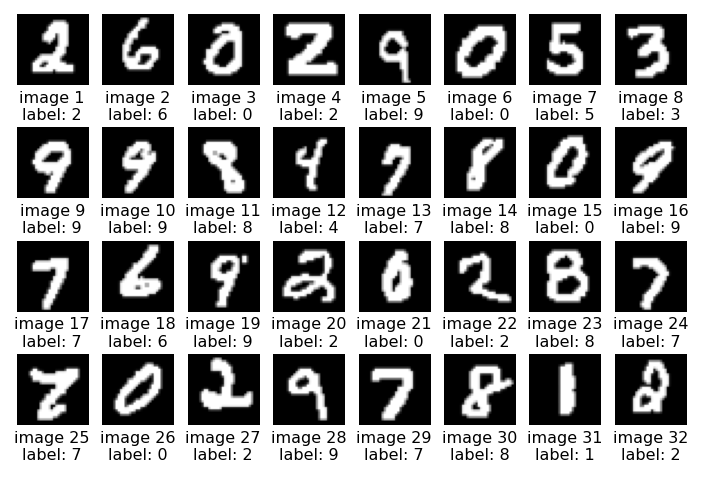

In [5]:
from matplotlib import pyplot as plt
import numpy as np


print("The 32 images with label of the first batch in ds_train are showed below:")
ds_iterator = ds_train.create_dict_iterator()
ds_iterator.get_next()
batch_1 = ds_iterator.get_next()
batch_image = batch_1["image"].asnumpy()
batch_label = batch_1["label"].asnumpy()
%matplotlib inline
plt.figure(dpi=144)
for i,image in enumerate(batch_image):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    image = np.transpose(image,(1,2,0))
    plt.imshow(image, cmap='gray')
    plt.title(f"image {i+1}\nlabel: {batch_label[i]}", y=-0.65, fontdict={"fontsize":8})
    plt.axis('off')    
plt.show()

## 预训练模型

运行以下一段代码进行预训练，生成后续加载模型进行推理或迁移学习所需的预训练模型CheckPoint文件。

In [6]:
from src.lenet import LeNet5
import mindspore.nn as nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy


network = LeNet5(args.num_classes)
net_loss = CrossEntropyLoss()
net_opt = nn.Momentum(network.trainable_params(), args.lr, args.momentum)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=args.save_checkpoint_steps,
                             keep_checkpoint_max=args.keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=args.ckpt_path, config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

print("============== Starting Training ==============")
model.train(args['epoch_size'], ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(per_print_times=375)], dataset_sink_mode=False)

============== Starting Training ==============
epoch: 1 step: 375, loss is 2.2927473
epoch: 1 step: 750, loss is 2.305515
epoch: 1 step: 1125, loss is 0.24555273
epoch: 1 step: 1500, loss is 0.082906224
epoch: 1 step: 1875, loss is 0.13226506
Epoch time: 35656.104, per step time: 19.017


预训练完成后，在`ckpt`目录下生成CheckPoint模型文件（`checkpoint_lenet-1_1875.ckpt`文件）。此时`ckpt`目录结构如下：

```bash
$ tree ckpt
ckpt
├── checkpoint_lenet-1_1875.ckpt
└── checkpoint_lenet-graph.meta
```

## 加载模型用于推理验证

针对仅推理场景可以使用`load_checkpoint`方法把参数直接加载到网络中，以便进行后续的推理验证。

使用`load_checkpoint`方法，导入预训练模型文件`checkpoint_lenet-1_1875.ckpt`中的参数到网络中。

其中：
- `load_checkpoint`方法会把参数文件中的网络参数加载到模型中。加载后，网络中的参数就是CheckPoint保存的参数。
- `eval`方法会验证训练后模型的精度。

运行以下一段代码，进行本地模型加载进行推理验证，得到推理精度值数据。

In [7]:
import os
import mindspore.nn as nn
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from src.dataset import create_dataset
from src.lenet import LeNet5

network = LeNet5(args.num_classes)
net_loss = CrossEntropyLoss()
load_checkpoint(ckpt_file_name="./ckpt/checkpoint_lenet-1_1875.ckpt", net=network)
model = Model(network, net_loss, metrics={"Accuracy": Accuracy()})

print("============== Starting Testing ==============")
ds_eval = create_dataset(os.path.join(args.data_path, "test"),
                         args.batch_size,
                         1)

acc = model.eval(ds_eval, dataset_sink_mode=False)
print("============== {} ==============".format(acc))

============== Starting Testing ==============
============== {'Accuracy': 0.9610376602564102} ==============


通过运行的输出结果得到推理精度达到0.96以上。

## 加载模型用于迁移学习

针对任务中断再训练及微调（Fine Tune）场景，可以加载网络参数和优化器参数到模型中。

同理，使用`load_checkpoint`接口导入预训练模型文件`checkpoint_lenet-3_1875.ckpt`，并使用`load_param_into_net`接口将预训练模型参数加载进网络中。

其中：
- `load_checkpoint`方法会返回一个预训练模型中的参数字典。
- `load_param_into_net`会把参数字典中相应的参数加载到网络或优化器中。

运行以下一段代码，进行本地模型加载并进行迁移学习（重训练）。在重训练过程中使用损失函数`SoftmaxCrossEntropyWithLogits`。

In [8]:
network = LeNet5(args.num_classes)
net_opt = nn.Momentum(network.trainable_params(), args.lr, args.momentum)
# return a parameter dict for model
param_dict = load_checkpoint(ckpt_file_name="./ckpt/checkpoint_lenet-1_1875.ckpt")
# load the parameter into net
load_param_into_net(network, param_dict)
# load the parameter into operator
load_param_into_net(net_opt, param_dict)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=args.save_checkpoint_steps,
                             keep_checkpoint_max=args.keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=args.ckpt_path, config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
ds_train = create_dataset(os.path.join(args.data_path, "train"), args.batch_size)

print("============== Starting Training ==============")
model.train(3, ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(per_print_times=375)], dataset_sink_mode=False)

============== Starting Training ==============
epoch: 1 step: 375, loss is 0.37688553
epoch: 1 step: 750, loss is 0.013124315
epoch: 1 step: 1125, loss is 0.085881285
epoch: 1 step: 1500, loss is 0.21028748
epoch: 1 step: 1875, loss is 0.12869717
Epoch time: 35499.356, per step time: 18.933
epoch: 2 step: 375, loss is 0.016073877
epoch: 2 step: 750, loss is 0.088704035
epoch: 2 step: 1125, loss is 0.33733696
epoch: 2 step: 1500, loss is 0.01171217
epoch: 2 step: 1875, loss is 0.023540335
Epoch time: 34577.878, per step time: 18.442
epoch: 3 step: 375, loss is 0.18325758
epoch: 3 step: 750, loss is 0.03311517
epoch: 3 step: 1125, loss is 0.010184636
epoch: 3 step: 1500, loss is 0.035022907
epoch: 3 step: 1875, loss is 0.0037345
Epoch time: 34550.868, per step time: 18.427


完成重训练后，将在CheckPoint文件保存目录生成新的CheckPoint文件。此时`./ckpt`目录结构为：

```bash
$ tree ckpt
ckpt
├── checkpoint_lenet_1-1_1875.ckpt
├── checkpoint_lenet-1_1875.ckpt
├── checkpoint_lenet_1-2_1875.ckpt
├── checkpoint_lenet_1-3_1875.ckpt
├── checkpoint_lenet_1-graph.meta
└── checkpoint_lenet-graph.meta
```

可以看出重训练保存的新的CheckPoint文件为`checkpoint_lenet_1-3_1875.ckpt`。

运行以下一段代码，使用`eval`方法测试加载模型重训练后的得到的新的模型的精度。

In [9]:
network = LeNet5(args.num_classes)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), args.lr, args.momentum)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

print("============== Starting Testing ==============")
load_checkpoint(ckpt_file_name="./ckpt/checkpoint_lenet_1-3_1875.ckpt", net=network)
ds_eval = create_dataset(os.path.join(args.data_path, "test"),
                         args.batch_size,
                         1)

acc = model.eval(ds_eval, dataset_sink_mode=False)
print("============== {} ==============".format(acc))

============== Starting Testing ==============
============== {'Accuracy': 0.9838741987179487} ==============


通过输出结果，得到重训练后模型的精度达到0.98以上，优于使用预训练得到的模型进行推理的精度。

## 总结

通过以上流程，完成了在本地加载预训练模型并用于推理验证和迁移学习的体验过程，了解了使用MindSpore的`load_checkpoint`方法和`load_param_into_net`方法加载模型的方式和过程。通过加载模型进行验证或迁移学习，可以在提高精度的同时有效减少训练时间，减小数据集规模，提高开发效率。